In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set()

In [2]:
class HIVTreatment:
    def __init__(self, args):
        self.state_names = ("T1", "T1*", "T2", "T2*", "V", "E")
    
        self.continuous_dims = np.arange(6)
        self.actions = np.array([[0., 0.], [.7, 0.], [0., .3], [.7, .3]])
        self.nA = 4
        self.episodeCap = args.episodeCap  #: total of 1000 days with a measurement every 5 days
        self.dt = 5  #: measurement every 5 days
        self.logspace = True  #: whether observed states are in log10 space or not
        #: only update the graphs in showDomain every x steps
        self.show_domain_every = 20
        # store samples of current episode for drawing
        self.episode_data = np.zeros((7, self.episodeCap + 1))

        if self.logspace:
            self.statespace_limits = np.array([[-5, 8]] * 6)
        else:
            self.statespace_limits = np.array([[0., 1e8]] * 6)
        self.state_space_dims = 6
        
        self.action_noise = args.action_noise
        self.action_sigma = args.action_sigma
        self.drop_p = args.drop_p
        
    def step(self, a):
        self.t += 1

        eps1, eps2 = self.actions[a]
        drop = False
        for mini_step in range(self.dt):
            eps1_noisy = max(eps1 + np.random.normal(self.action_noise, self.action_sigma), 0.0)
            eps2_noisy = max(eps2 + np.random.normal(self.action_noise, self.action_sigma), 0.0)
            
            p_drop = self.drop_p * (self.dt + 1 - mini_step)**-1
            if np.random.rand() <= p_drop or drop:
                eps1_noisy = 0
                eps2_noisy = 0
                drop = True
            ns = odeint(dsdt, self.state, [0, 1], #changed [0, dt] to [0, 1]
                    args=(eps1_noisy, eps2_noisy), mxstep=1000)[-1]
            T1, T2, T1s, T2s, V, E = ns
            # the reward function penalizes treatment because of side-effects
            reward = (- 0.1 * V - 2e4 * eps1_noisy ** 2 - 2e3 * eps2_noisy ** 2 + 1e3 * E)/1e5
            self.state = ns.copy()
            if self.logspace:
                ns = np.log10(ns)

        self.episode_data[:-1, self.t] = self.state
        self.episode_data[-1, self.t - 1] = a
        return self.normalizeState(ns), reward, self.isTerminal(), self.possibleActions()
    def normalizeState(self, s):
        return (s - self.statespace_limits[:, 0])/(self.statespace_limits[:, 1] - self.statespace_limits[:, 0])
    def isTerminal(self):
        return self.t >= self.episodeCap
    
    def possibleActions(self):
        return np.arange(4)

    def reset(self):
        self.t = 0
        self.episode_data[:] = np.nan
        # non-healthy stable state of the system
        s = np.array([163573., 5., 11945., 46., 63919., 24.])
        self.state = s.copy()
        self.episode_data[:-1, 0] = s
        if self.logspace:
            s = np.log10(s)
        return self.normalizeState(s)

def dsdt(s, t, eps1, eps2):
    """
    system derivate per time. The unit of time are days.
    """
    # model parameter constants
    lambda1 = 1e4
    lambda2 = 31.98
    d1 = 0.01
    d2 = 0.01
    f = .34
    k1 = 8e-7
    k2 = 1e-4
    delta = .7
    m1 = 1e-5
    m2 = 1e-5
    NT = 100.
    c = 13.
    rho1 = 1.
    rho2 = 1.
    lambdaE = 1
    bE = 0.3
    Kb = 100
    d_E = 0.25
    Kd = 500
    deltaE = 0.1

    # decompose state
    T1, T2, T1s, T2s, V, E = s

    # compute derivatives
    tmp1 = (1. - eps1) * k1 * V * T1
    tmp2 = (1. - f * eps1) * k2 * V * T2
    dT1 = lambda1 - d1 * T1 - tmp1
    dT2 = lambda2 - d2 * T2 - tmp2
    dT1s = tmp1 - delta * T1s - m1 * E * T1s
    dT2s = tmp2 - delta * T2s - m2 * E * T2s
    dV = (1. - eps2) * NT * delta * (T1s + T2s) - c * V \
        - ((1. - eps1) * rho1 * k1 * T1 +
           (1. - f * eps1) * rho2 * k2 * T2) * V
    dE = lambdaE + bE * (T1s + T2s) / (T1s + T2s + Kb) * E \
        - d_E * (T1s + T2s) / (T1s + T2s + Kd) * E - deltaE * E

    return np.array([dT1, dT2, dT1s, dT2s, dV, dE])

### Test Policy

Let's find the optimal policy for a short horizion

In [90]:
args = Namespace(**{'action_noise': 0, 'drop_p':0, 'action_sigma':0,\
                   'episodeCap': 4, 'num_episode': 1000, 'ifCVaR': True, 'opt': 0,\
                   'save_name': 'egreedy', 'alpha': 0.25, 'gamma': 0.99})
env = HIVTreatment(args)

In [2]:
def cv(res, alpha=0.25):
    cvar = np.zeros(res.shape[0])
    var = np.sort(res)[int(len(res) * alpha)]
    idx = np.where(res <= var)
    cvar = np.mean(res[idx])
    return cvar

In [92]:
from itertools import product
ret_cv = []
ret_mean = []
pi = []
for i in product([0, 1, 2, 3], repeat=4): 
    pi.append(list(i))
    s = env.reset()
    ret_pi = []
    for tr in range(100):
        s = env.reset()
        j = 0; t=False
        ret = []
        while not t:
            s, r, t, info = env.step(pi[-1][j])
            ret.append(r)
            j += 1
        ret_pi.append(discounted_return(ret, args.gamma))
    ret_pi = np.array(ret_pi)
    ret_cv.append(cv(ret_pi, args.alpha))
    ret_mean.append(np.mean(ret_pi))

Text(0.5,0,'return')

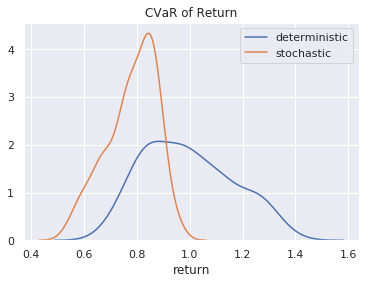

In [97]:
#st_cv = ret_cv
#st_mean = ret_mean
sns.kdeplot(ret_cv, label='deterministic')
sns.kdeplot(st_cv, label='stochastic')
plt.title('CVaR of Return')
plt.xlabel('return')

Text(0.5,0,'return')

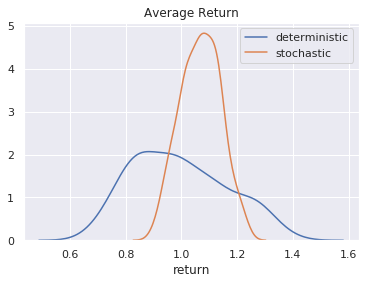

In [96]:
sns.kdeplot(ret_mean, label='deterministic')
sns.kdeplot(st_mean, label='stochastic')
plt.title('Average Return')
plt.xlabel('return')

0.5533346918043969
0.9516742002751399


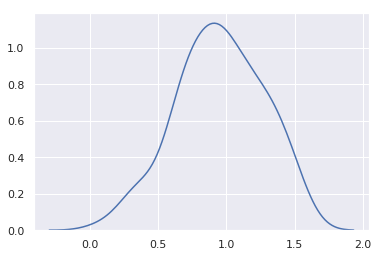

In [86]:
sns.kdeplot(ret_pi)
print(cv(ret_pi, args.alpha))
print(np.mean(ret_pi))

In [87]:
idx = np.argmax(ret_mean)
print(idx)
print(pi[idx][:])
print(np.max(ret_mean))
idx = np.argmax(ret_cv)
print(idx)
print(pi[idx][:])
print(np.max(ret_cv))
print(ret_cv[56])

226
[3, 2, 0, 2]
1.2279255854058886
104
[1, 2, 2, 0]
0.964168567762034
0.8574140411890862


In [18]:
# test to see if it's deterministc

0.46491852080582674


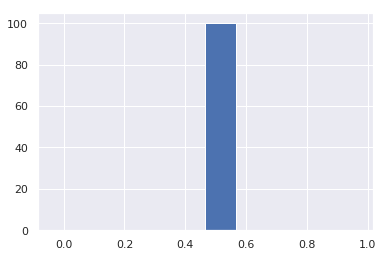

In [9]:
ret_dist = []
pi = [2, 2]
for i in range(100):
    s = env.reset()
    ret = []
    for j in range(2):
        s, r, t, info = env.step(pi[j])
        ret.append(r)
    ret_dist.append(discounted_return(ret, 0.99))
plt.hist(ret_dist)
print(np.mean(ret_dist))

### e-greedy learning of the average

In [3]:
from core import config, drl, replay
import tensorflow as tf
from argparse import Namespace

def discounted_return(returns, gamma):
    ret = 0
    for r in reversed(returns):
        ret = r + gamma * ret
    return ret

/home/ramtin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [114]:
args = Namespace(**{'action_noise': 0, 'drop_p':0, 'action_sigma':0,\
                   'episodeCap': 20, 'num_episode': 6000, 'ifCVaR': False, 'opt': 0,\
                   'save_name': 'egreedy', 'alpha': 0.25, 'gamma': 0.99})
tf.reset_default_graph()
with tf.Session() as sess:
    env = HIVTreatment(args)
    Config = config.config(env, args)
    Config.max_step = env.episodeCap
    
    returns = np.zeros((Config.args.num_episode, 2))
    replay_buffer = replay.Replay(Config, load=False)
    counts = np.ones((1, Config.nA))
    C51 = drl.C51(Config, ifCVaR=Config.args.ifCVaR, memory=replay_buffer)
    saver = tf.train.Saver()
    sess.run(tf.initializers.global_variables())
    print("[*] TF model initialized")

    summary_writer = tf.summary.FileWriter(args.save_name + '/summary', sess.graph)
    C51_loss = []
    train_step = 0
    
    for ep in range(Config.args.num_episode):
        terminal = False
        step = 0
        lr = Config.get_lr(ep)
        epsilon = Config.get_epsilon(ep)
 
        episode_return = []
        observation = env.reset()
        pi = []
        while not terminal:
            if np.random.rand() <= epsilon:
                action_id = np.random.randint(Config.nA)
            else:
                if Config.args.ifCVaR:
                    o = np.expand_dims(observation, axis=0)
                    counts = np.ones((1, Config.nA))
                    distribution = C51.predict(sess, o)
                    values = C51.CVaRopt(distribution, count=counts,\
                                 alpha=Config.args.alpha, N=Config.CVaRSamples, c=args.opt, bonus=0.0)
                else:
                    o = np.expand_dims(observation, axis=0)
                    distribution = C51.predict(sess, o)
                    values = C51.Q(distribution)
                action_id = np.random.choice(np.flatnonzero(values == values.max()))
            next_observation, reward, terminal, info = env.step(action_id)
            pi.append(action_id)
            step += 1
            no = np.expand_dims(next_observation, axis=0)
            next_counts = counts # hack to avoind passing counts
            episode_return.append(reward)
            if step >= Config.max_step:
                terminal = True
                 
            replay_buffer.add(observation, action_id, reward, terminal,\
                                 counts, next_counts)
            # Training:
            l, _ = C51.train(sess=sess, size=Config.train_size, opt=args.opt, learning_rate = lr)
                         
            #if ep%Config.summary_write_episode == 0 and summary is not None:
            #    summary_writer.add_summary(summary, train_step)
            train_step += 1
            if l is not None:
                C51_loss.append(l)
                returns[ep, 1] = l
            observation = next_observation   
        returns[ep, 0] = discounted_return(episode_return, Config.args.gamma)
        if ep%Config.print_episode == 0:
            print("Training.  Episode ep:%3d, Discounted Return = %g, Epsilon = %g, Lr = %g, C51 average loss=%g"\
                         %(ep, returns[ep, 0], epsilon, lr, np.mean(C51_loss)))
        if ep% Config.save_episode == 0:
            save_file = {'ep': ep, 'returns': returns}
            replay_buffer.save(args.save_name)
            pickle_in = open(args.save_name + '.p', 'wb')
            pickle.dump(save_file, pickle_in)
            pickle_in.close()
            saver.save(sess, args.save_name + '.ckpt')

Initialzing the replay buffer
[*] TF model initialized
Training.  Episode ep:  0, Discounted Return = 6.50758, Epsilon = 0.9, Lr = 0.001, C51 average loss=3.80667
Replay buffer saved, name:egreedy.p
Training.  Episode ep:100, Discounted Return = 12.0893, Epsilon = 0.871667, Lr = 0.00097, C51 average loss=2.57689
Training.  Episode ep:200, Discounted Return = 6.89592, Epsilon = 0.843333, Lr = 0.00094, C51 average loss=2.62348
Training.  Episode ep:300, Discounted Return = 9.77344, Epsilon = 0.815, Lr = 0.00091, C51 average loss=2.57397
Training.  Episode ep:400, Discounted Return = 7.61423, Epsilon = 0.786667, Lr = 0.00088, C51 average loss=2.53355
Training.  Episode ep:500, Discounted Return = 7.17879, Epsilon = 0.758333, Lr = 0.00085, C51 average loss=2.49657
Training.  Episode ep:600, Discounted Return = 3.5874, Epsilon = 0.73, Lr = 0.00082, C51 average loss=2.46368
Training.  Episode ep:700, Discounted Return = 6.77362, Epsilon = 0.701667, Lr = 0.00079, C51 average loss=2.43773
Trai

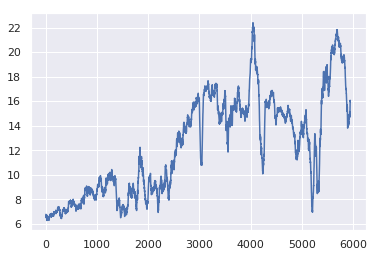

In [128]:
plt.plot(mv(returns[:, 0], 50))

In [7]:
def mv(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

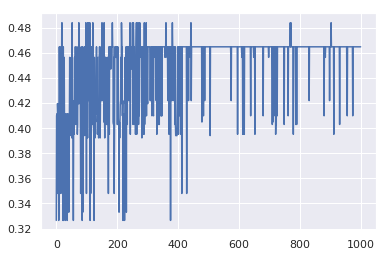

In [8]:
plt.plot(returns[:, 0])

In [26]:
Config.args.gamma

0.99

## Determinisitic Env, with 20 actionable steps and full period

In [24]:
data = pickle.load(open('results/det_exp_test_5000.p', 'rb'))

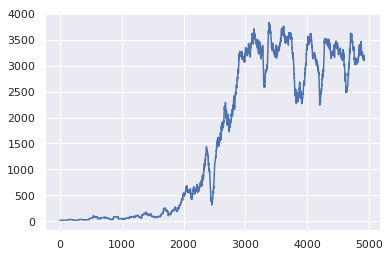

In [27]:
plt.plot(mv(data['returns'][:5000, 0], 75))

In [200]:
## Stochastic Env, with 20 actionable steps and full period, 5 diff stochasticity


In [4]:
def cv(res, alpha=0.25):
    cvar = np.zeros(res.shape[0])
    var = np.sort(res)[int(len(res) * alpha)]
    idx = np.where(res <= var)
    cvar = np.mean(res[idx])
    return cvar

Text(0.5,1,'CVaR s')

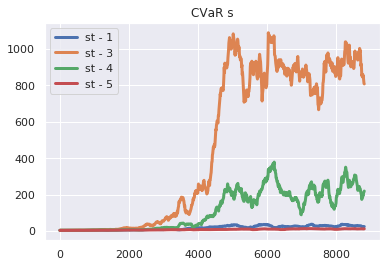

In [58]:
sam = 1000
for ii in [1, 3, 4, 5]:
    data = pickle.load(open('results/st%d_exp_arch3_9000.p'%(ii), 'rb'))
    returns = data['returns'][:9000, 0]
    cv_ret = returns.reshape((sam, -1))
    num = returns.shape[0]
    c = np.zeros((sam))
    for i in range(sam):
        c[i] = cv(cv_ret[i, :])
    ep = np.arange(sam) * num/sam
    plt.plot(ep[:-19], mv(c, 20), label='st - %d'%(ii), linewidth = 3)
plt.legend()
plt.title("CVaR s")

Text(0.5,1,'Retuns')

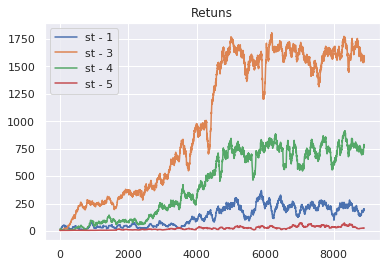

In [256]:
## Stochastic Env, with 20 actionable steps and full period, 5 diff stochasticity
for i in [1, 3, 4, 5]:
    data = pickle.load(open('results/st%d_exp_arch3_9000.p'%(i), 'rb'))

    plt.plot(mv(data['returns'][:9000, 0], 100), label = 'st - %d'%(i))
plt.legend()
plt.title("Retuns")

Now, let's take last 4000 episodes and look at the returns

In [69]:
data = pickle.load(open('results/st3_exp_arch1_9000.p', 'rb'))['returns'][6000:9000, 0]

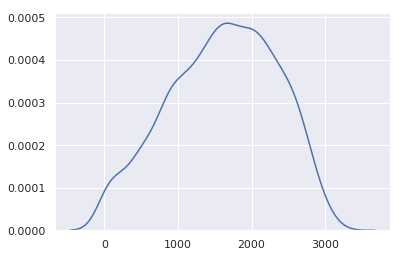

In [70]:
sns.kdeplot(data)

In [72]:
## Let's load the model and see the results

INFO:tensorflow:Restoring parameters from results/st_cvar_25.ckpt
[*] TF model restored
New Ep
[0.78567012 0.43838231 0.69824509 0.51251983 0.75427923 0.49078548]


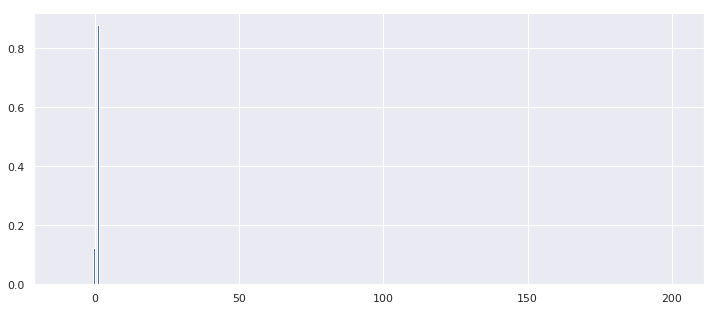

[0.82220076 0.60765405 0.54715689 0.52677231 0.61667908 0.49443413]


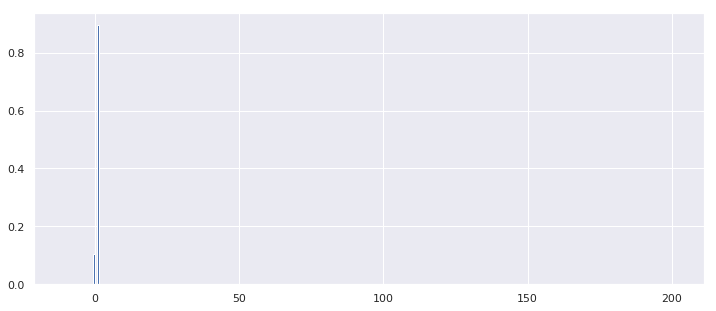

[0.82966813 0.45966105 0.6868316  0.51291695 0.74274475 0.51645047]


KeyboardInterrupt: 

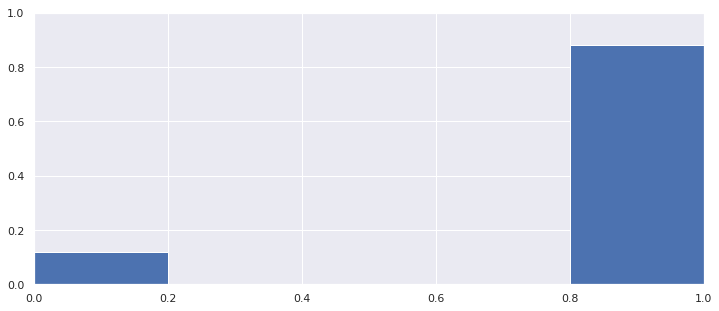

In [28]:
from utils.hiv_env import *

args = Namespace(**{'action_noise': 0, 'drop_p':0, 'action_sigma':0,\
                   'episodeCap': 20, 'num_episode': 5000, 'ifCVaR': True, 'opt': 0,\
                   'save_name': 'ssss', 'alpha': 0.25, 'gamma': 0.99,\
                    'load_name': 'results/st_cvar_25',\
                   'arch': 2, 'st': 3, 'seed': 1, 'actionable_time_steps': 20, 'normalize_state' : True,\
                   'normalize_reward': True})
tf.reset_default_graph()
with tf.Session() as sess:
    env = HIVTreatment(args)
    Config = config.config(env, args)
    Config.max_step = env.episodeCap
    
    load_file = pickle.load(open(args.load_name + '_3000.p', 'rb'))
    counts = np.ones((1, Config.nA))
    C51 = drl.C51(Config, ifCVaR=Config.args.ifCVaR, memory=None)
    returns = load_file["returns"]
    initial_ep = load_file["ep"]
    saver = tf.train.Saver()
    saver.restore(sess, args.load_name + '.ckpt')
    print("[*] TF model restored")
    
    tot_return = []
    for ep in range(10):
        terminal = False
        step = 0
        lr = Config.get_lr(ep)
        epsilon = Config.get_epsilon(ep)
 
        episode_return = []
        observation = env.reset()
        pi = []
        print('New Ep')
        while not terminal:
            o = np.expand_dims(observation, axis=0)
            counts = np.ones((1, Config.nA))
            distribution = C51.predict(sess, o)
            values = C51.CVaRopt(distribution, count=counts,\
                         alpha=Config.args.alpha, N=Config.CVaRSamples, c=args.opt, bonus=0.0)
               
            print(observation)
            o = np.expand_dims(observation, axis=0)
            distribution = C51.predict(sess, o)
            plt.figure(figsize=(12,5))
            #plt.bar(np.linspace(-10, 200, 151), distribution[0][0, :])
            plt.bar(np.linspace(-10, 200, 151), distribution[0][0, :])
            #plt.bar(np.linspace(-10, 200, 151), distribution[0][0, :])
            #plt.bar(np.linspace(-10, 200, 151), distribution[0][0, :])
            plt.show()
            #values = C51.Q(distribution)
            #print(values)
            action_id = np.random.choice(np.flatnonzero(values == values.max()))
            next_observation, reward, terminal, info = env.step(action_id)
            pi.append(action_id)
            step += 1
            no = np.expand_dims(next_observation, axis=0)
            next_counts = counts # hack to avoind passing counts
            episode_return.append(reward)
            if step >= Config.max_step:
                terminal = True
                 
            observation = next_observation   
        tot_return.append(discounted_return(episode_return, Config.args.gamma))
        print(ep, discounted_return(episode_return, Config.args.gamma))

(array([4., 1., 1., 1., 0., 1., 1., 0., 0., 1.]),
 array([0.03198053, 0.03279757, 0.03361461, 0.03443165, 0.03524868,
        0.03606572, 0.03688276, 0.0376998 , 0.03851684, 0.03933388,
        0.04015091]),
 <a list of 10 Patch objects>)

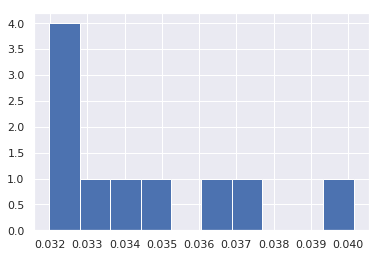

In [43]:
#Bad_retunr = tot_return
#Good_Return = tot_return
plt.hist(tot_return)
#plt.figure()
#sns.kdeplot(Good_Return)

In [48]:
tot_return

[0.06265297314092372,
 0.04510981035405549,
 0.03440722069784657,
 0.07149068293597159,
 0.04019544925405184,
 0.08160549709339066,
 0.035089878943534374]

So it does make sense, now let's see if CVaR learning would do something

## Testing E-greedy
actionable time steps 100

In [5]:
def cv(res, alpha=0.25):
    cvar = np.zeros(res.shape[0])
    var = np.sort(res)[int(len(res) * alpha)]
    idx = np.where(res <= var)
    cvar = np.mean(res[idx])
    return cvar

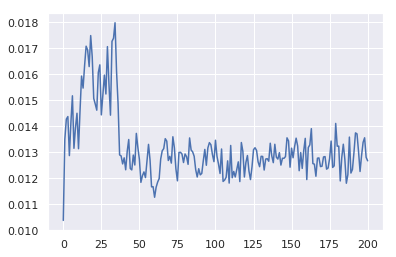

In [195]:
data = pickle.load(open('results/st_cvar_seed_%d_20000.p'%(1), 'rb'))
cvar = np.zeros(data['evaluation_returns'].shape[0])
for j in range(data['evaluation_returns'].shape[0]):
    cvar[j] = cv(data['evaluation_returns'][j, :])
res = cvar

for i in range(2,4):
    data = pickle.load(open('results/st_cvar_seed_%d_20000.p'%(i), 'rb'))
    cvar = np.zeros(data['evaluation_returns'].shape[0])
    for j in range(data['evaluation_returns'].shape[0]):
        cvar[j] = cv(data['evaluation_returns'][j, :])
    res += cvar
res /= 4
plt.plot(res)

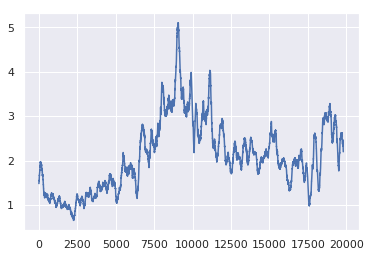

In [264]:
data = pickle.load(open('results/st_exp_seed1_20000.p', 'rb'))
res = mv(data['returns'][:, 0], 200)
for i in range(2,5):
    data = pickle.load(open('results/st_exp_seed%d_20000.p'%(i), 'rb'))
    res += mv(data['returns'][:, 0], 200)
res /= 5
plt.plot(res)

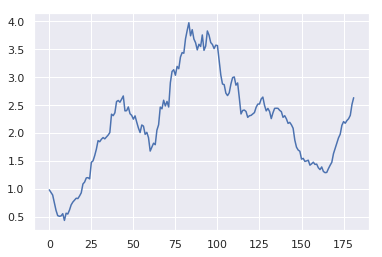

In [191]:
data = pickle.load(open('results/st_exp_seed1_20000.p', 'rb'))
res = mv(np.mean(data['evaluation_returns'], axis = 1), 20)
for i in range(2,5):
    data = pickle.load(open('results/st_exp_seed%d_20000.p'%(i), 'rb'))
    res += mv(np.mean(data['evaluation_returns'], axis = 1), 20)
res /= 5
plt.plot(res)

This seems like the amount of stochasticty is high

In [201]:
#Loweing the actioable steps

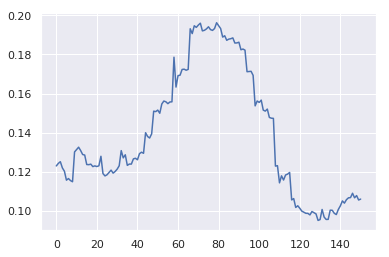

In [295]:
data = pickle.load(open('results/st_cvar_20_seed_1_2500.p', 'rb'))
res = mv(data['returns'][:200, 0], 50)
#plt.plot(res)

## Checking again
Actionable steps 20, exectation, stochasticity small

Text(0.5,1,'Retuns')

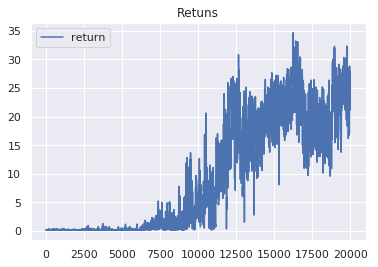

In [91]:
data = pickle.load(open('results/st_exp_20_seed%d_20000.p'%(1), 'rb'))
res = mv(data['returns'][:20000, 0], 10)
for i in [2, 3, 4]:
    data = pickle.load(open('results/st_exp_20_seed%d_20000.p'%(i), 'rb'))
    res += mv(data['returns'][:20000, 0], 10)
res /= 4
plt.plot(res, label = 'return')
plt.legend()
plt.title("Retuns")

Text(0.5,1,'Retuns')

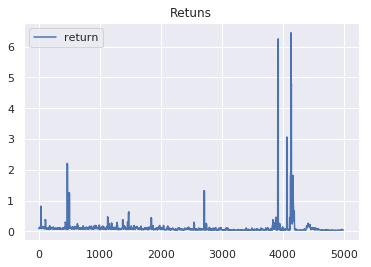

In [93]:
data = pickle.load(open('results/st_cvar_20_seed_%d_5000.p'%(1), 'rb'))
res = mv(data['returns'][:5000, 0], 10)
plt.plot(res, label = 'return')
plt.legend()
plt.title("Retuns")

In [15]:
data = pickle.load(open('results/st_cvar_50_05_seed_%d_30000.p'%(1), 'rb'))
res = mv(data['returns'][:20000, 0], 10)
plt.plot(res, label = 'return')
plt.legend()
plt.title("Retuns")

FileNotFoundError: [Errno 2] No such file or directory: 'results/st_cvar_50_05_seed_1_30000.p'

### Lets Look at the CVaR learnig

In [88]:
from utils.hiv_env import *

args = Namespace(**{'action_noise': 0, 'drop_p':0, 'action_sigma':0,\
                   'episodeCap': 20, 'num_episode': 10000, 'ifCVaR': True, 'opt': 0,\
                   'save_name': 'egreedy', 'alpha': 0.99, 'gamma': 0.99, 'load_name': 'results/st3_exp_arch1',\
                   'arch': 1, 'st': 3, 'seed': 1, 'actionable_time_steps': 20, 'normalize_state' : True,\
                   'normalize_reward': True})
tf.reset_default_graph()
with tf.Session() as sess:
    env = HIVTreatment(args)
    Config = config.config(env, args)
    Config.max_step = env.episodeCap
    
    returns = np.zeros((Config.args.num_episode, 2))
    replay_buffer = replay.Replay(Config, load=False)
    counts = np.ones((1, Config.nA))
    C51 = drl.C51(Config, ifCVaR=Config.args.ifCVaR, memory=replay_buffer)
    saver = tf.train.Saver()
    sess.run(tf.initializers.global_variables())
    print("[*] TF model initialized")

    summary_writer = tf.summary.FileWriter(args.save_name + '/summary', sess.graph)
    C51_loss = []
    train_step = 0
    
    for ep in range(Config.args.num_episode):
        terminal = False
        step = 0
        lr = Config.get_lr(ep)
        epsilon = Config.get_epsilon(ep)
 
        episode_return = []
        observation = env.reset()
        pi = []
        while not terminal:
            if np.random.rand() <= epsilon:
                action_id = np.random.randint(Config.nA)
            else:
                if Config.args.ifCVaR:
                    o = np.expand_dims(observation, axis=0)
                    counts = np.ones((1, Config.nA))
                    distribution = C51.predict(sess, o)
                    values = C51.CVaRopt(distribution, count=counts,\
                                 alpha=Config.args.alpha, N=Config.CVaRSamples, c=args.opt, bonus=0.0)
                else:
                    o = np.expand_dims(observation, axis=0)
                    distribution = C51.predict(sess, o)
                    values = C51.Q(distribution)
                action_id = np.random.choice(np.flatnonzero(values == values.max()))
            next_observation, reward, terminal, info = env.step(action_id)
            pi.append(action_id)
            step += 1
            no = np.expand_dims(next_observation, axis=0)
            next_counts = counts # hack to avoind passing counts
            episode_return.append(reward)
            if step >= Config.max_step:
                terminal = True
                 
            replay_buffer.add(observation, action_id, reward, terminal,\
                                 counts, next_counts)
            # Training:
            l, _ = C51.train(sess=sess, size=Config.train_size, opt=args.opt, learning_rate = lr)
                         
            #if ep%Config.summary_write_episode == 0 and summary is not None:
            #    summary_writer.add_summary(summary, train_step)
            train_step += 1
            if l is not None:
                C51_loss.append(l)
                returns[ep, 1] = l
            observation = next_observation   
        returns[ep, 0] = discounted_return(episode_return, Config.args.gamma)
        if ep%Config.print_episode == 0:
            print("Training.  Episode ep:%3d, Discounted Return = %g, Epsilon = %g, Lr = %g, C51 average loss=%g"\
                         %(ep, returns[ep, 0], epsilon, lr, np.mean(C51_loss)))
        if ep% Config.save_episode == 0:
            save_file = {'ep': ep, 'returns': returns}
            replay_buffer.save(args.save_name)
            pickle_in = open(args.save_name + '.p', 'wb')
            pickle.dump(save_file, pickle_in)
            pickle_in.close()
            saver.save(sess, args.save_name + '.ckpt')

Initialzing the replay buffer
[*] TF model initialized
Training.  Episode ep:  0, Discounted Return = 0.153634, Epsilon = 0.9, Lr = 0.001, C51 average loss=3.85905
Replay buffer saved, name:egreedy.p
Training.  Episode ep:  1, Discounted Return = 0.0798481, Epsilon = 0.89983, Lr = 0.00099982, C51 average loss=3.85809
Training.  Episode ep:  2, Discounted Return = 0.0679328, Epsilon = 0.89966, Lr = 0.00099964, C51 average loss=3.85176
Training.  Episode ep:  3, Discounted Return = 0.0513158, Epsilon = 0.89949, Lr = 0.00099946, C51 average loss=3.84774
Training.  Episode ep:  4, Discounted Return = 0.344894, Epsilon = 0.89932, Lr = 0.00099928, C51 average loss=3.83551
Training.  Episode ep:  5, Discounted Return = 0.0532806, Epsilon = 0.89915, Lr = 0.0009991, C51 average loss=3.81919
Training.  Episode ep:  6, Discounted Return = 0.121284, Epsilon = 0.89898, Lr = 0.00099892, C51 average loss=3.80594
Training.  Episode ep:  7, Discounted Return = 0.0905195, Epsilon = 0.89881, Lr = 0.00099

Training.  Episode ep: 69, Discounted Return = 0.178975, Epsilon = 0.88827, Lr = 0.00098758, C51 average loss=2.85846
Training.  Episode ep: 70, Discounted Return = 0.0601408, Epsilon = 0.8881, Lr = 0.0009874, C51 average loss=2.85083
Training.  Episode ep: 71, Discounted Return = 0.0865317, Epsilon = 0.88793, Lr = 0.00098722, C51 average loss=2.8435
Training.  Episode ep: 72, Discounted Return = 0.127774, Epsilon = 0.88776, Lr = 0.00098704, C51 average loss=2.83656
Training.  Episode ep: 73, Discounted Return = 0.0447609, Epsilon = 0.88759, Lr = 0.00098686, C51 average loss=2.82923
Training.  Episode ep: 74, Discounted Return = 0.0412381, Epsilon = 0.88742, Lr = 0.00098668, C51 average loss=2.8218
Training.  Episode ep: 75, Discounted Return = 0.0948858, Epsilon = 0.88725, Lr = 0.0009865, C51 average loss=2.81403
Training.  Episode ep: 76, Discounted Return = 0.17307, Epsilon = 0.88708, Lr = 0.00098632, C51 average loss=2.80779
Training.  Episode ep: 77, Discounted Return = 0.181779, 

Training.  Episode ep:139, Discounted Return = 0.124976, Epsilon = 0.87637, Lr = 0.00097498, C51 average loss=2.57597
Training.  Episode ep:140, Discounted Return = 0.0301544, Epsilon = 0.8762, Lr = 0.0009748, C51 average loss=2.57402
Training.  Episode ep:141, Discounted Return = 0.082044, Epsilon = 0.87603, Lr = 0.00097462, C51 average loss=2.57244
Training.  Episode ep:142, Discounted Return = 0.0345331, Epsilon = 0.87586, Lr = 0.00097444, C51 average loss=2.57088
Training.  Episode ep:143, Discounted Return = 0.22308, Epsilon = 0.87569, Lr = 0.00097426, C51 average loss=2.56894
Training.  Episode ep:144, Discounted Return = 0.23074, Epsilon = 0.87552, Lr = 0.00097408, C51 average loss=2.56703
Training.  Episode ep:145, Discounted Return = 0.192814, Epsilon = 0.87535, Lr = 0.0009739, C51 average loss=2.56526
Training.  Episode ep:146, Discounted Return = 0.0767572, Epsilon = 0.87518, Lr = 0.00097372, C51 average loss=2.56339
Training.  Episode ep:147, Discounted Return = 0.149805, E

Training.  Episode ep:209, Discounted Return = 0.0762565, Epsilon = 0.86447, Lr = 0.00096238, C51 average loss=2.49336
Training.  Episode ep:210, Discounted Return = 0.154893, Epsilon = 0.8643, Lr = 0.0009622, C51 average loss=2.49128
Training.  Episode ep:211, Discounted Return = 0.202024, Epsilon = 0.86413, Lr = 0.00096202, C51 average loss=2.48947
Training.  Episode ep:212, Discounted Return = 0.100834, Epsilon = 0.86396, Lr = 0.00096184, C51 average loss=2.48946
Training.  Episode ep:213, Discounted Return = 0.0525663, Epsilon = 0.86379, Lr = 0.00096166, C51 average loss=2.49005
Training.  Episode ep:214, Discounted Return = 0.0622046, Epsilon = 0.86362, Lr = 0.00096148, C51 average loss=2.49023
Training.  Episode ep:215, Discounted Return = 0.0653176, Epsilon = 0.86345, Lr = 0.0009613, C51 average loss=2.49082
Training.  Episode ep:216, Discounted Return = 0.052386, Epsilon = 0.86328, Lr = 0.00096112, C51 average loss=2.49181
Training.  Episode ep:217, Discounted Return = 0.109259

Training.  Episode ep:279, Discounted Return = 0.17926, Epsilon = 0.85257, Lr = 0.00094978, C51 average loss=2.44886
Training.  Episode ep:280, Discounted Return = 0.0677137, Epsilon = 0.8524, Lr = 0.0009496, C51 average loss=2.44858
Training.  Episode ep:281, Discounted Return = 0.11706, Epsilon = 0.85223, Lr = 0.00094942, C51 average loss=2.44822
Training.  Episode ep:282, Discounted Return = 0.0538105, Epsilon = 0.85206, Lr = 0.00094924, C51 average loss=2.44798
Training.  Episode ep:283, Discounted Return = 0.0599356, Epsilon = 0.85189, Lr = 0.00094906, C51 average loss=2.4476
Training.  Episode ep:284, Discounted Return = 0.100605, Epsilon = 0.85172, Lr = 0.00094888, C51 average loss=2.4472
Training.  Episode ep:285, Discounted Return = 0.0453338, Epsilon = 0.85155, Lr = 0.0009487, C51 average loss=2.4469
Training.  Episode ep:286, Discounted Return = 0.150669, Epsilon = 0.85138, Lr = 0.00094852, C51 average loss=2.4464
Training.  Episode ep:287, Discounted Return = 0.0773897, Eps

Training.  Episode ep:349, Discounted Return = 0.0361316, Epsilon = 0.84067, Lr = 0.00093718, C51 average loss=2.39971
Training.  Episode ep:350, Discounted Return = 0.198422, Epsilon = 0.8405, Lr = 0.000937, C51 average loss=2.39882
Training.  Episode ep:351, Discounted Return = 0.0582577, Epsilon = 0.84033, Lr = 0.00093682, C51 average loss=2.3982
Training.  Episode ep:352, Discounted Return = 0.0716695, Epsilon = 0.84016, Lr = 0.00093664, C51 average loss=2.3979
Training.  Episode ep:353, Discounted Return = 0.0491837, Epsilon = 0.83999, Lr = 0.00093646, C51 average loss=2.39783
Training.  Episode ep:354, Discounted Return = 0.094822, Epsilon = 0.83982, Lr = 0.00093628, C51 average loss=2.39746
Training.  Episode ep:355, Discounted Return = 0.0992919, Epsilon = 0.83965, Lr = 0.0009361, C51 average loss=2.39687
Training.  Episode ep:356, Discounted Return = 0.0887512, Epsilon = 0.83948, Lr = 0.00093592, C51 average loss=2.39641
Training.  Episode ep:357, Discounted Return = 0.0520523

Training.  Episode ep:419, Discounted Return = 0.229386, Epsilon = 0.82877, Lr = 0.00092458, C51 average loss=2.36829
Training.  Episode ep:420, Discounted Return = 0.105683, Epsilon = 0.8286, Lr = 0.0009244, C51 average loss=2.3681
Training.  Episode ep:421, Discounted Return = 0.0955378, Epsilon = 0.82843, Lr = 0.00092422, C51 average loss=2.36772
Training.  Episode ep:422, Discounted Return = 0.355126, Epsilon = 0.82826, Lr = 0.00092404, C51 average loss=2.36711
Training.  Episode ep:423, Discounted Return = 0.0404336, Epsilon = 0.82809, Lr = 0.00092386, C51 average loss=2.36635
Training.  Episode ep:424, Discounted Return = 0.111608, Epsilon = 0.82792, Lr = 0.00092368, C51 average loss=2.36559
Training.  Episode ep:425, Discounted Return = 0.0477335, Epsilon = 0.82775, Lr = 0.0009235, C51 average loss=2.36486
Training.  Episode ep:426, Discounted Return = 0.0652547, Epsilon = 0.82758, Lr = 0.00092332, C51 average loss=2.36428
Training.  Episode ep:427, Discounted Return = 0.0372367

Training.  Episode ep:489, Discounted Return = 0.889615, Epsilon = 0.81687, Lr = 0.00091198, C51 average loss=2.34904
Training.  Episode ep:490, Discounted Return = 0.0953004, Epsilon = 0.8167, Lr = 0.0009118, C51 average loss=2.34906
Training.  Episode ep:491, Discounted Return = 0.176109, Epsilon = 0.81653, Lr = 0.00091162, C51 average loss=2.34889
Training.  Episode ep:492, Discounted Return = 0.0388852, Epsilon = 0.81636, Lr = 0.00091144, C51 average loss=2.34861
Training.  Episode ep:493, Discounted Return = 0.0560945, Epsilon = 0.81619, Lr = 0.00091126, C51 average loss=2.34823
Training.  Episode ep:494, Discounted Return = 0.0731481, Epsilon = 0.81602, Lr = 0.00091108, C51 average loss=2.34786
Training.  Episode ep:495, Discounted Return = 0.0505577, Epsilon = 0.81585, Lr = 0.0009109, C51 average loss=2.3473
Training.  Episode ep:496, Discounted Return = 0.071438, Epsilon = 0.81568, Lr = 0.00091072, C51 average loss=2.34659
Training.  Episode ep:497, Discounted Return = 0.046527

Training.  Episode ep:559, Discounted Return = 0.109997, Epsilon = 0.80497, Lr = 0.00089938, C51 average loss=2.32378
Training.  Episode ep:560, Discounted Return = 0.0620856, Epsilon = 0.8048, Lr = 0.0008992, C51 average loss=2.32336
Training.  Episode ep:561, Discounted Return = 0.292084, Epsilon = 0.80463, Lr = 0.00089902, C51 average loss=2.32297
Training.  Episode ep:562, Discounted Return = 0.0602093, Epsilon = 0.80446, Lr = 0.00089884, C51 average loss=2.32263
Training.  Episode ep:563, Discounted Return = 0.195437, Epsilon = 0.80429, Lr = 0.00089866, C51 average loss=2.32234
Training.  Episode ep:564, Discounted Return = 0.0578405, Epsilon = 0.80412, Lr = 0.00089848, C51 average loss=2.32212
Training.  Episode ep:565, Discounted Return = 0.105673, Epsilon = 0.80395, Lr = 0.0008983, C51 average loss=2.32191
Training.  Episode ep:566, Discounted Return = 0.129863, Epsilon = 0.80378, Lr = 0.00089812, C51 average loss=2.32155
Training.  Episode ep:567, Discounted Return = 0.0567869

Training.  Episode ep:629, Discounted Return = 0.0536225, Epsilon = 0.79307, Lr = 0.00088678, C51 average loss=2.297
Training.  Episode ep:630, Discounted Return = 0.0308233, Epsilon = 0.7929, Lr = 0.0008866, C51 average loss=2.29655
Training.  Episode ep:631, Discounted Return = 0.0431538, Epsilon = 0.79273, Lr = 0.00088642, C51 average loss=2.29609
Training.  Episode ep:632, Discounted Return = 0.11738, Epsilon = 0.79256, Lr = 0.00088624, C51 average loss=2.29565
Training.  Episode ep:633, Discounted Return = 0.0413158, Epsilon = 0.79239, Lr = 0.00088606, C51 average loss=2.2953
Training.  Episode ep:634, Discounted Return = 0.0492598, Epsilon = 0.79222, Lr = 0.00088588, C51 average loss=2.295
Training.  Episode ep:635, Discounted Return = 0.0891347, Epsilon = 0.79205, Lr = 0.0008857, C51 average loss=2.29471
Training.  Episode ep:636, Discounted Return = 0.131146, Epsilon = 0.79188, Lr = 0.00088552, C51 average loss=2.29442
Training.  Episode ep:637, Discounted Return = 0.0932773, E

Training.  Episode ep:699, Discounted Return = 0.344812, Epsilon = 0.78117, Lr = 0.00087418, C51 average loss=2.26349
Training.  Episode ep:700, Discounted Return = 0.443424, Epsilon = 0.781, Lr = 0.000874, C51 average loss=2.26293
Replay buffer saved, name:egreedy.p
Training.  Episode ep:701, Discounted Return = 0.0770694, Epsilon = 0.78083, Lr = 0.00087382, C51 average loss=2.26239
Training.  Episode ep:702, Discounted Return = 0.0873444, Epsilon = 0.78066, Lr = 0.00087364, C51 average loss=2.26183
Training.  Episode ep:703, Discounted Return = 0.0403215, Epsilon = 0.78049, Lr = 0.00087346, C51 average loss=2.26129
Training.  Episode ep:704, Discounted Return = 0.0779971, Epsilon = 0.78032, Lr = 0.00087328, C51 average loss=2.26079
Training.  Episode ep:705, Discounted Return = 0.139626, Epsilon = 0.78015, Lr = 0.0008731, C51 average loss=2.26036
Training.  Episode ep:706, Discounted Return = 0.120629, Epsilon = 0.77998, Lr = 0.00087292, C51 average loss=2.25993
Training.  Episode ep

Training.  Episode ep:769, Discounted Return = 0.221044, Epsilon = 0.76927, Lr = 0.00086158, C51 average loss=2.22952
Training.  Episode ep:770, Discounted Return = 0.131087, Epsilon = 0.7691, Lr = 0.0008614, C51 average loss=2.22909
Training.  Episode ep:771, Discounted Return = 0.082443, Epsilon = 0.76893, Lr = 0.00086122, C51 average loss=2.22863
Training.  Episode ep:772, Discounted Return = 0.0897353, Epsilon = 0.76876, Lr = 0.00086104, C51 average loss=2.2282
Training.  Episode ep:773, Discounted Return = 0.081321, Epsilon = 0.76859, Lr = 0.00086086, C51 average loss=2.22772
Training.  Episode ep:774, Discounted Return = 0.126722, Epsilon = 0.76842, Lr = 0.00086068, C51 average loss=2.22719
Training.  Episode ep:775, Discounted Return = 0.0502515, Epsilon = 0.76825, Lr = 0.0008605, C51 average loss=2.22673
Training.  Episode ep:776, Discounted Return = 0.212257, Epsilon = 0.76808, Lr = 0.00086032, C51 average loss=2.22633
Training.  Episode ep:777, Discounted Return = 0.0804921, 

Training.  Episode ep:839, Discounted Return = 0.0722816, Epsilon = 0.75737, Lr = 0.00084898, C51 average loss=2.1916
Training.  Episode ep:840, Discounted Return = 0.101949, Epsilon = 0.7572, Lr = 0.0008488, C51 average loss=2.19105
Training.  Episode ep:841, Discounted Return = 0.0704106, Epsilon = 0.75703, Lr = 0.00084862, C51 average loss=2.19054
Training.  Episode ep:842, Discounted Return = 0.19319, Epsilon = 0.75686, Lr = 0.00084844, C51 average loss=2.19
Training.  Episode ep:843, Discounted Return = 0.0657351, Epsilon = 0.75669, Lr = 0.00084826, C51 average loss=2.18951
Training.  Episode ep:844, Discounted Return = 0.0870041, Epsilon = 0.75652, Lr = 0.00084808, C51 average loss=2.18902
Training.  Episode ep:845, Discounted Return = 0.0835056, Epsilon = 0.75635, Lr = 0.0008479, C51 average loss=2.18854
Training.  Episode ep:846, Discounted Return = 0.033142, Epsilon = 0.75618, Lr = 0.00084772, C51 average loss=2.18804
Training.  Episode ep:847, Discounted Return = 0.0500984, E

Training.  Episode ep:909, Discounted Return = 0.163245, Epsilon = 0.74547, Lr = 0.00083638, C51 average loss=2.15081
Training.  Episode ep:910, Discounted Return = 0.069082, Epsilon = 0.7453, Lr = 0.0008362, C51 average loss=2.15011
Training.  Episode ep:911, Discounted Return = 0.0879904, Epsilon = 0.74513, Lr = 0.00083602, C51 average loss=2.14945
Training.  Episode ep:912, Discounted Return = 0.189078, Epsilon = 0.74496, Lr = 0.00083584, C51 average loss=2.14876
Training.  Episode ep:913, Discounted Return = 0.234443, Epsilon = 0.74479, Lr = 0.00083566, C51 average loss=2.14807
Training.  Episode ep:914, Discounted Return = 0.0420972, Epsilon = 0.74462, Lr = 0.00083548, C51 average loss=2.14737
Training.  Episode ep:915, Discounted Return = 0.0464494, Epsilon = 0.74445, Lr = 0.0008353, C51 average loss=2.14664
Training.  Episode ep:916, Discounted Return = 0.043967, Epsilon = 0.74428, Lr = 0.00083512, C51 average loss=2.1459
Training.  Episode ep:917, Discounted Return = 0.115719, 

Training.  Episode ep:979, Discounted Return = 0.120024, Epsilon = 0.73357, Lr = 0.00082378, C51 average loss=2.09862
Training.  Episode ep:980, Discounted Return = 0.0910082, Epsilon = 0.7334, Lr = 0.0008236, C51 average loss=2.09791
Training.  Episode ep:981, Discounted Return = 0.0423004, Epsilon = 0.73323, Lr = 0.00082342, C51 average loss=2.09716
Training.  Episode ep:982, Discounted Return = 0.0971051, Epsilon = 0.73306, Lr = 0.00082324, C51 average loss=2.09637
Training.  Episode ep:983, Discounted Return = 0.0996305, Epsilon = 0.73289, Lr = 0.00082306, C51 average loss=2.09557
Training.  Episode ep:984, Discounted Return = 0.0390097, Epsilon = 0.73272, Lr = 0.00082288, C51 average loss=2.09482
Training.  Episode ep:985, Discounted Return = 0.0700478, Epsilon = 0.73255, Lr = 0.0008227, C51 average loss=2.09408
Training.  Episode ep:986, Discounted Return = 0.061162, Epsilon = 0.73238, Lr = 0.00082252, C51 average loss=2.0933
Training.  Episode ep:987, Discounted Return = 0.04241

Training.  Episode ep:1048, Discounted Return = 0.0372131, Epsilon = 0.72184, Lr = 0.00081136, C51 average loss=2.04321
Training.  Episode ep:1049, Discounted Return = 0.0738889, Epsilon = 0.72167, Lr = 0.00081118, C51 average loss=2.0424
Training.  Episode ep:1050, Discounted Return = 0.0542514, Epsilon = 0.7215, Lr = 0.000811, C51 average loss=2.04155
Training.  Episode ep:1051, Discounted Return = 0.148615, Epsilon = 0.72133, Lr = 0.00081082, C51 average loss=2.04075
Training.  Episode ep:1052, Discounted Return = 0.127883, Epsilon = 0.72116, Lr = 0.00081064, C51 average loss=2.03996
Training.  Episode ep:1053, Discounted Return = 0.062689, Epsilon = 0.72099, Lr = 0.00081046, C51 average loss=2.03917
Training.  Episode ep:1054, Discounted Return = 0.0605948, Epsilon = 0.72082, Lr = 0.00081028, C51 average loss=2.03836
Training.  Episode ep:1055, Discounted Return = 0.0783422, Epsilon = 0.72065, Lr = 0.0008101, C51 average loss=2.03756
Training.  Episode ep:1056, Discounted Return = 

Training.  Episode ep:1117, Discounted Return = 0.0689575, Epsilon = 0.71011, Lr = 0.00079894, C51 average loss=1.99035
Training.  Episode ep:1118, Discounted Return = 0.108155, Epsilon = 0.70994, Lr = 0.00079876, C51 average loss=1.98958
Training.  Episode ep:1119, Discounted Return = 0.322293, Epsilon = 0.70977, Lr = 0.00079858, C51 average loss=1.98886
Training.  Episode ep:1120, Discounted Return = 0.0787225, Epsilon = 0.7096, Lr = 0.0007984, C51 average loss=1.98815
Training.  Episode ep:1121, Discounted Return = 0.156434, Epsilon = 0.70943, Lr = 0.00079822, C51 average loss=1.98751
Training.  Episode ep:1122, Discounted Return = 0.0452502, Epsilon = 0.70926, Lr = 0.00079804, C51 average loss=1.98686
Training.  Episode ep:1123, Discounted Return = 3.09249, Epsilon = 0.70909, Lr = 0.00079786, C51 average loss=1.9862
Training.  Episode ep:1124, Discounted Return = 0.217681, Epsilon = 0.70892, Lr = 0.00079768, C51 average loss=1.9855
Training.  Episode ep:1125, Discounted Return = 0.

Training.  Episode ep:1186, Discounted Return = 0.0637065, Epsilon = 0.69838, Lr = 0.00078652, C51 average loss=1.95809
Training.  Episode ep:1187, Discounted Return = 0.0583516, Epsilon = 0.69821, Lr = 0.00078634, C51 average loss=1.9579
Training.  Episode ep:1188, Discounted Return = 0.0916754, Epsilon = 0.69804, Lr = 0.00078616, C51 average loss=1.95772
Training.  Episode ep:1189, Discounted Return = 0.199251, Epsilon = 0.69787, Lr = 0.00078598, C51 average loss=1.95752
Training.  Episode ep:1190, Discounted Return = 0.0905747, Epsilon = 0.6977, Lr = 0.0007858, C51 average loss=1.95733
Training.  Episode ep:1191, Discounted Return = 0.48115, Epsilon = 0.69753, Lr = 0.00078562, C51 average loss=1.95712
Training.  Episode ep:1192, Discounted Return = 0.053787, Epsilon = 0.69736, Lr = 0.00078544, C51 average loss=1.95691
Training.  Episode ep:1193, Discounted Return = 0.0787058, Epsilon = 0.69719, Lr = 0.00078526, C51 average loss=1.95666
Training.  Episode ep:1194, Discounted Return =

Training.  Episode ep:1255, Discounted Return = 0.0398098, Epsilon = 0.68665, Lr = 0.0007741, C51 average loss=1.94534
Training.  Episode ep:1256, Discounted Return = 0.105812, Epsilon = 0.68648, Lr = 0.00077392, C51 average loss=1.94513
Training.  Episode ep:1257, Discounted Return = 0.115007, Epsilon = 0.68631, Lr = 0.00077374, C51 average loss=1.9449
Training.  Episode ep:1258, Discounted Return = 0.059144, Epsilon = 0.68614, Lr = 0.00077356, C51 average loss=1.94467
Training.  Episode ep:1259, Discounted Return = 0.0698171, Epsilon = 0.68597, Lr = 0.00077338, C51 average loss=1.94447
Training.  Episode ep:1260, Discounted Return = 0.212227, Epsilon = 0.6858, Lr = 0.0007732, C51 average loss=1.94428
Training.  Episode ep:1261, Discounted Return = 0.0572632, Epsilon = 0.68563, Lr = 0.00077302, C51 average loss=1.94411
Training.  Episode ep:1262, Discounted Return = 0.135601, Epsilon = 0.68546, Lr = 0.00077284, C51 average loss=1.94394
Training.  Episode ep:1263, Discounted Return = 0

Training.  Episode ep:1324, Discounted Return = 0.096992, Epsilon = 0.67492, Lr = 0.00076168, C51 average loss=1.9319
Training.  Episode ep:1325, Discounted Return = 0.115685, Epsilon = 0.67475, Lr = 0.0007615, C51 average loss=1.93172
Training.  Episode ep:1326, Discounted Return = 0.0548801, Epsilon = 0.67458, Lr = 0.00076132, C51 average loss=1.93155
Training.  Episode ep:1327, Discounted Return = 0.0829368, Epsilon = 0.67441, Lr = 0.00076114, C51 average loss=1.93135
Training.  Episode ep:1328, Discounted Return = 0.0463867, Epsilon = 0.67424, Lr = 0.00076096, C51 average loss=1.93116
Training.  Episode ep:1329, Discounted Return = 0.044332, Epsilon = 0.67407, Lr = 0.00076078, C51 average loss=1.93099
Training.  Episode ep:1330, Discounted Return = 0.378431, Epsilon = 0.6739, Lr = 0.0007606, C51 average loss=1.93079
Training.  Episode ep:1331, Discounted Return = 0.174521, Epsilon = 0.67373, Lr = 0.00076042, C51 average loss=1.9306
Training.  Episode ep:1332, Discounted Return = 0.

Training.  Episode ep:1393, Discounted Return = 0.112812, Epsilon = 0.66319, Lr = 0.00074926, C51 average loss=1.921
Training.  Episode ep:1394, Discounted Return = 0.249958, Epsilon = 0.66302, Lr = 0.00074908, C51 average loss=1.92084
Training.  Episode ep:1395, Discounted Return = 0.0740845, Epsilon = 0.66285, Lr = 0.0007489, C51 average loss=1.92066
Training.  Episode ep:1396, Discounted Return = 0.0964168, Epsilon = 0.66268, Lr = 0.00074872, C51 average loss=1.92049
Training.  Episode ep:1397, Discounted Return = 0.230968, Epsilon = 0.66251, Lr = 0.00074854, C51 average loss=1.92031
Training.  Episode ep:1398, Discounted Return = 0.131154, Epsilon = 0.66234, Lr = 0.00074836, C51 average loss=1.92013
Training.  Episode ep:1399, Discounted Return = 0.0835893, Epsilon = 0.66217, Lr = 0.00074818, C51 average loss=1.91995
Training.  Episode ep:1400, Discounted Return = 0.0386459, Epsilon = 0.662, Lr = 0.000748, C51 average loss=1.91978
Replay buffer saved, name:egreedy.p
Training.  Epis

Training.  Episode ep:1462, Discounted Return = 0.186069, Epsilon = 0.65146, Lr = 0.00073684, C51 average loss=1.90812
Training.  Episode ep:1463, Discounted Return = 0.06907, Epsilon = 0.65129, Lr = 0.00073666, C51 average loss=1.90791
Training.  Episode ep:1464, Discounted Return = 9.70643, Epsilon = 0.65112, Lr = 0.00073648, C51 average loss=1.9077
Training.  Episode ep:1465, Discounted Return = 0.0627258, Epsilon = 0.65095, Lr = 0.0007363, C51 average loss=1.9075
Training.  Episode ep:1466, Discounted Return = 0.0414343, Epsilon = 0.65078, Lr = 0.00073612, C51 average loss=1.90731
Training.  Episode ep:1467, Discounted Return = 0.0695756, Epsilon = 0.65061, Lr = 0.00073594, C51 average loss=1.90711
Training.  Episode ep:1468, Discounted Return = 0.0482397, Epsilon = 0.65044, Lr = 0.00073576, C51 average loss=1.90691
Training.  Episode ep:1469, Discounted Return = 0.0477699, Epsilon = 0.65027, Lr = 0.00073558, C51 average loss=1.90669
Training.  Episode ep:1470, Discounted Return = 

KeyboardInterrupt: 

In [26]:
distribution[0][0, :]

array([0.00041412, 0.00079101, 0.00121044, 0.0021352 , 0.05644689,
       0.14053512, 0.08895361, 0.07264431, 0.0725786 , 0.0709537 ,
       0.06459846, 0.0642939 , 0.04687731, 0.03519905, 0.02560551,
       0.01824448, 0.01354052, 0.01154389, 0.0038457 , 0.00283734,
       0.00322577, 0.00510526, 0.00388001, 0.00436872, 0.00531665,
       0.00762717, 0.0117435 , 0.01156049, 0.01157706, 0.0152828 ,
       0.0140852 , 0.01751502, 0.01426043, 0.01131374, 0.01147894,
       0.00981098, 0.00863346, 0.00683462, 0.00632484, 0.00494275,
       0.00389662, 0.00358871, 0.00294538, 0.00247592, 0.00243829,
       0.00201583, 0.00157575, 0.00119226, 0.00075635, 0.00064111,
       0.00033714], dtype=float32)

In [ ]:
data = pickle.load(open('egreedy.p', 'rb'))
res = data['returns'][:1800, 0]
plt.plot(res, label = 'return')
plt.legend()
plt.title("Retuns")

In [ ]:
python egreedy.py --save_name 'results/st_exp_20_seed1' --seed 1 --gamma 0.99 --num_episode 20000 --actionable_time_steps 20 --st 3 --arch 2
